In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the style using seaborn
sns.set_style("whitegrid", {"grid.color": ".9"})
sns.set_context("paper", font_scale=1, rc={"axes.linewidth": 1.5})

# Parameters for balancing the bins
max_freq = 28628  # Maximum frequency allowed for each bin
max_upsample = 50  # Maximum times a bin can be upsampled

df = pd.read_csv('data/ibtracs/ibtracs_gridsat_train.csv')

def gini(frequencies):
    sum_abs_diff = 0
    # average of the sample
    mu = np.sum(frequencies) / len(frequencies)
    for frequency_out in frequencies:
        for frequency_in in frequencies:
            abs_diff = np.abs(frequency_out - frequency_in)
            sum_abs_diff += abs_diff
 
    return sum_abs_diff/ (2*len(frequencies)**2*mu)

C:\Users\ascen\AppData\Local\Temp\ipykernel_34096\1226865233.py:14: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/ibtracs/ibtracs_gridsat_train.csv')


In [2]:
bins_saffir_simpson = [0, 34, 64, 83, 96, 113, 137, 200]  # Modify as necessary

df['AUG'] = 0  # Initialize the 'AUG' column in the original dataframe

# Re-bin the data into the extended Saffir-Simpson scale bins
df['binned_ss'] = pd.cut(df['WMO_WIND'], bins_saffir_simpson, right=False, include_lowest=True)

# Counting the frequency of each new bin
frequency_ss = df['binned_ss'].value_counts().sort_index()

# Calculate Gini coefficient for the original distribution
gini_original = gini(frequency_ss.values)

# Print the count of each SS class before re-balancing and the corresponding Gini score
print("Original Saffir-Simpson Class Counts:")
print(frequency_ss)
print(f"Gini Coefficient of the original distribution: {gini_original:.4f}")

Original Saffir-Simpson Class Counts:
binned_ss
[0, 34)       20490
[34, 64)      28628
[64, 83)       9353
[83, 96)       4155
[96, 113)      2084
[113, 137)     1058
[137, 200)      102
Name: count, dtype: int64
Gini Coefficient of the original distribution: 0.5713


In [3]:
# Balancing the bins
balanced_frequency = frequency_ss.copy()
for bin_, freq in balanced_frequency.items():
    # If the frequency is greater than the maximum allowed, reduce it to max_freq
    if freq > max_freq:
        balanced_frequency[bin_] = max_freq
    # If the frequency is less than max_freq, try to upsample
    elif freq < max_freq:
        balanced_frequency[bin_] = min(freq * max_upsample, max_freq)

# Calculate Gini coefficient for the new balanced distribution
gini_balanced = gini(balanced_frequency.values)

balanced_frequency, gini_balanced

(binned_ss
 [0, 34)       28628
 [34, 64)      28628
 [64, 83)      28628
 [83, 96)      28628
 [96, 113)     28628
 [113, 137)    28628
 [137, 200)     5100
 Name: count, dtype: int64,
 0.1140220794200033)

In [4]:
df['AUG'] = 0

# Initialize an empty DataFrame to hold the rebalanced data
df_balanced = pd.DataFrame()

for bin_, target_freq in balanced_frequency.items():
    # Filter rows for the current bin
    bin_rows = df[df['binned_ss'] == bin_].copy()

    if len(bin_rows) > target_freq:
        # If the bin has too many rows, randomly remove some
        df_balanced = pd.concat([df_balanced, bin_rows.sample(n=target_freq)], ignore_index=True)
    elif len(bin_rows) < target_freq:
        # If the bin has too few rows, duplicate random rows
        # Calculate how many duplicates are needed
        duplicates_needed = target_freq - len(bin_rows)
        # Append the original bin rows
        df_balanced = pd.concat([df_balanced, bin_rows], ignore_index=True)
        # Randomly sample duplicates from the original bin rows and append
        duplicates = bin_rows.sample(n=duplicates_needed, replace=True).copy()
        duplicates['AUG'] = 1  # Mark duplicates as augmented
        df_balanced = pd.concat([df_balanced, duplicates], ignore_index=True)
    else:
        # If the bin has exactly the right amount of rows, just append all
        df_balanced = pd.concat([df_balanced, bin_rows], ignore_index=True)

C:\Users\ascen\AppData\Local\Temp\ipykernel_34096\1136890984.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_balanced['CATEGORY'], bins=bins_saffir_simpson, kde=False,
C:\Users\ascen\AppData\Local\Temp\ipykernel_34096\1136890984.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['CATEGORY'], bins=bins_saffir_simpson, kde=False,


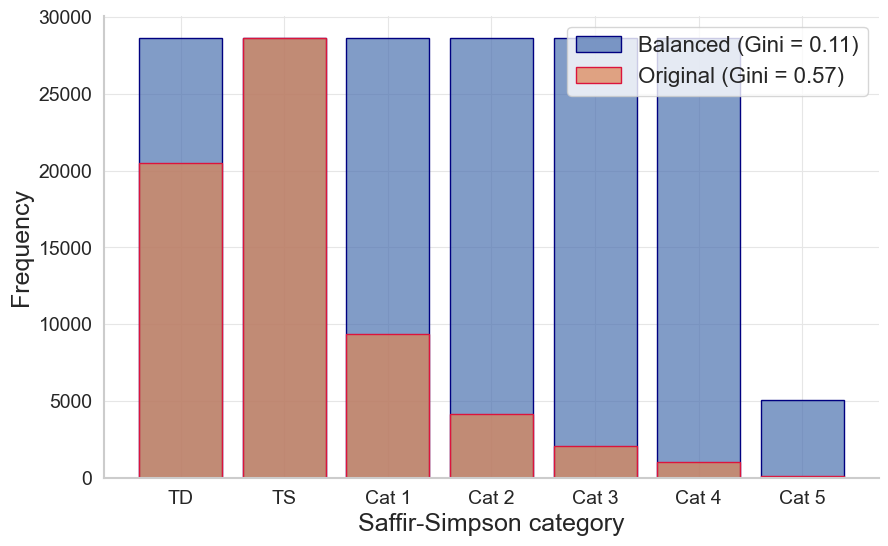

In [8]:
# Setting up the style using seaborn
sns.set_style("whitegrid", {"grid.color": ".9"})
sns.set_context("paper", font_scale=1, rc={"axes.linewidth": 1.5})

bins_saffir_simpson = [0, 1, 2, 3, 4, 5, 6, 7]  # Modify as necessary

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
palette = sns.color_palette("coolwarm", as_cmap=True)

# Creating the histogram with the 'shrink' parameter to add separation

sns.histplot(df_balanced['CATEGORY'], bins=bins_saffir_simpson, kde=False, 
             palette=palette, edgecolor="navy", linewidth=1, shrink=0.8, label='Balanced (Gini = 0.11)', alpha=0.7)
sns.histplot(df['CATEGORY'], bins=bins_saffir_simpson, kde=False, 
             palette=palette, edgecolor="crimson", linewidth=1, shrink=0.8, label='Original (Gini = 0.57)', alpha=0.7)

# sns.histplot(df_balanced['Wind_Category'], bins=bins_saffir_simpson, kde=False, 
#              palette=palette, edgecolor="crimson", linewidth=1, shrink=0.8, label='Balanced (Gini = 0.10)', alpha=0.7)

# Enhancing overall aesthetics
sns.set(style="whitegrid")
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Saffir-Simpson category', fontsize=18)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], labels=['TD', 'TS', 'Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'Cat 5'], fontsize=14)  # Update this line
plt.yticks(fontsize=14)

plt.legend(fontsize=16)

# Adding subtle artistic elements
ax.spines['right'].set_visible(False)
ax.spines['top']. set_visible(False)

# Show the updated plot
plt.show()

In [7]:
#df_balanced.to_csv(f'data/ibtracs/ibtracs_gridsat_train.gini_{gini_balanced}.max_freq_{max_freq}.max_upsample_{max_upsample}.csv', index=False)